In [1]:
import numpy as np
import pandas as pd
import os, re

import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import ttach as tta
import segmentation_models_pytorch as smp
from imantics import Polygons, Mask

import cv2
import albumentations as albu

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
PATH      = './train/'
TEST_PATH = './test'
CLASSES = ['Tumor', 'CA_CHA', 'PV_SMV', 'SMA']

RESIZE = 512

In [4]:
patients = [i for i in os.listdir(PATH) if i.startswith('Patient')]
test_patients = [i for i in os.listdir(TEST_PATH) if i.startswith('Patient')]

In [5]:
png_files_paths = []
for patient in patients:
    for sets in os.listdir(os.path.join(PATH, patient)):
        files = os.listdir(os.path.join(PATH, patient, sets))
        txt_files = [
            re.search("Slice_(\d*)", str(i)).group(0)
            for i in files
            if i.endswith('txt') and i.startswith('Slice')
        ]
        png_files_paths += [
            os.path.join(PATH, patient, sets, i) 
            for i in files 
            if i.endswith('png') and re.search("Slice_(\d*)", i).group(0) in txt_files
        ]

In [6]:
test_png_files_paths = []
for patient in test_patients:
    for sets in os.listdir(os.path.join(TEST_PATH, patient)):
        files = os.listdir(os.path.join(TEST_PATH, patient, sets))
        
        test_png_files_paths += [os.path.join(TEST_PATH, patient, sets, i) for i in files if i.endswith('png')]
        #txt_files = [os.path.join(PATH, patient, sets, i) for i in files if i.endswith('txt') and i!='CT_Image.txt']

In [7]:
# path is the path to a one txt file with coordinates
def make_one_mask(path):
    polygon = []
    with open(path) as f:
        for line in f:
            reg = re.search('{X=(.*), Y=(.*)}', line)
            x = int(reg.group(1))
            y = int(reg.group(2))
            polygon.append([x, y])

    mask = np.zeros((512, 512), dtype=np.int8)
    cv2.fillConvexPoly(mask, np.array(polygon), 1)
    return mask

#slice_mask should be a list of PATH/slice_{N}...txt, where N is same
def make_mask(slice_mask):
    mask = np.array(4*[np.zeros((512, 512))], dtype=np.int8)
    for i in ['Tumor', 'CA_CHA', 'PV_SMV', 'SMA']:
        for mask_coordinates in slice_mask:
            if i in mask_coordinates:
                mask[CLASSES.index(i)] |= make_one_mask(mask_coordinates)
    return mask

In [8]:
class Pancreatic_CT(Dataset):
    def __init__(
        self, 
        images_dir, 
        augmentation=None,
        preprocessing=None
    ):
        self.images_dir = images_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, i):
        image_path = self.images_dir[i]
        fileneme = image_path.split('/')[-1]
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        #laplacian = cv2.Laplacian(image, ddepth=cv2.CV_8U, ksize=5)
        
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)/255
        #image[:, :, 2] = laplacian
        
        slice_num = re.search('(.*)CT_Image.png', fileneme).group(1)
        parent_path = '/'.join(image_path.split('/')[:-1])
        txt_files = [
            parent_path + '/' + i \
            for i in os.listdir(parent_path) \
            if i.endswith('txt') and i!='CT_Image.txt'
        ]
        slice_mask = [i for i in txt_files if slice_num in i]
        mask = make_mask(slice_mask)
        if self.augmentation:
            sample = self.augmentation(image=image, masks=list(mask))
            image, mask = sample['image'], sample['masks']
        
        if self.preprocessing:
            image = self.preprocessing(image=image)['image']
            
        return torch.tensor(image, dtype=torch.float), \
               torch.tensor(mask, dtype=torch.float)
    
class Test_Pancreatic_CT(Dataset):
    def __init__(
        self, 
        images_dir, 
        augmentation=None,
        preprocessing=None
    ):
        self.images_dir = images_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, i):
        image_path = self.images_dir[i]
        fileneme = image_path.split('/')[-1]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        #laplacian = cv2.Laplacian(image, ddepth=cv2.CV_8U, ksize=5)
        
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)/255
        #image[:, :, 2] = laplacian
        
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        if self.preprocessing:
            image = self.preprocessing(image=image)['image']
            
        return torch.tensor(image, dtype=torch.float), \
               image_path

In [9]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(RESIZE, RESIZE),
        albu.ShiftScaleRotate(),
        albu.ElasticTransform(sigma=20, alpha_affine=20)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(RESIZE, RESIZE),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

In [10]:
train_paths, valid_paths = png_files_paths[:int(len(png_files_paths)*0.85)], png_files_paths[int(len(png_files_paths)*0.85):]
test_paths = test_png_files_paths

In [11]:
len(train_paths), len(valid_paths)

(7157, 1264)

In [12]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet' #'noisy-student'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
train_dataset = Pancreatic_CT(
    train_paths,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
valid_dataset = Pancreatic_CT(
    valid_paths, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=12, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=True)

In [14]:
test_dataset = Test_Pancreatic_CT(
    test_png_files_paths, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

954 ./train/Patient_45/Set_1/Slice_68_CT_Image.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


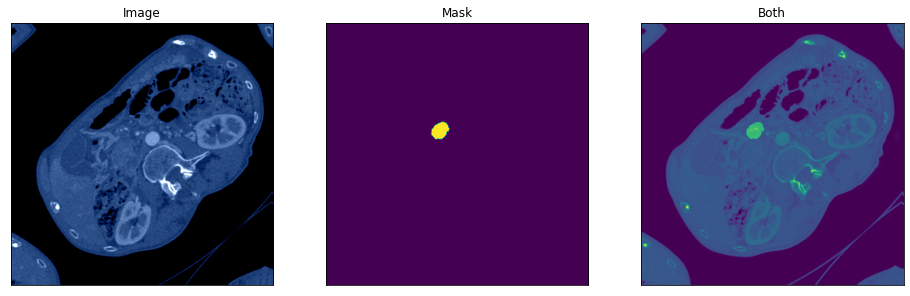

In [15]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

n = np.random.choice(len(valid_dataset))
cls = 0
print(n, train_paths[n])
image, mask = train_dataset[n]
visualize(
    image=image.permute(1, 2, 0), 
    mask=np.array(mask)[cls].squeeze(),
    both=np.array(mask)[cls].squeeze() + image[0].numpy() 
)

In [16]:
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=len(CLASSES), 
    activation=ACTIVATION
)

In [17]:
class SumThreeLosses(smp.utils.base.Loss):
    def __init__(self, l1, l2, l3, a, b, c):
        super().__init__(name='SumThreeLosses')
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, *inputs):
        return self.a * self.l1.forward(*inputs) + \
               self.b * self.l2.forward(*inputs) + \
               self.c * self.l3.forward(*inputs)

In [18]:
loss = \
SumThreeLosses(
    smp.losses.FocalLoss('binary'),
    smp.utils.losses.DiceLoss(),
    smp.utils.losses.BCELoss(),
    2, 1, 2
)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [26]:
# train model for 40 epochs
max_score = 0

In [28]:
PATIENCE = 5
patience = 0
for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f'./{model.name}_best_model.pth')
        print('Model saved!')
        patience = 0
    else:
        patience += 1
    
    if patience == PATIENCE:
        break


Epoch: 0
valid: 100%|██████████| 1264/1264 [00:44<00:00, 28.60it/s, SumThreeLosses - 0.7903, iou_score - 0.4715]

Epoch: 1
train:   0%|          | 4/1431 [00:04<24:59,  1.05s/it, SumThreeLosses - 0.4774, iou_score - 0.7873]  


KeyboardInterrupt: 

In [ ]:
# UNet++ resnet34
# Epochs: 14
# train: dice_loss + bce_loss - 0.164, iou_score - 0.7335
# valid: dice_loss + bce_loss - 0.4284, iou_score - 0.4737

In [30]:
best_model = torch.load(f'{model.name}_best_model.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


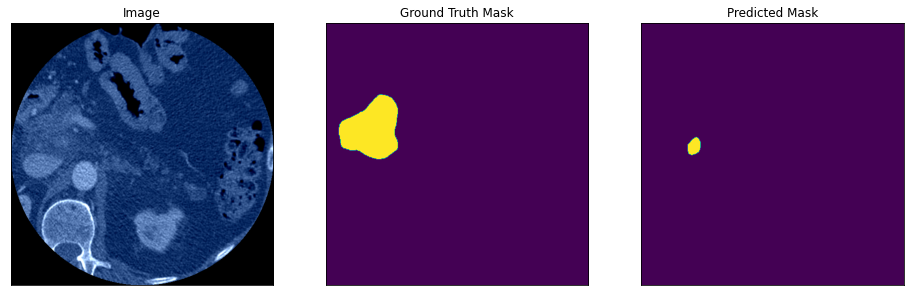

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


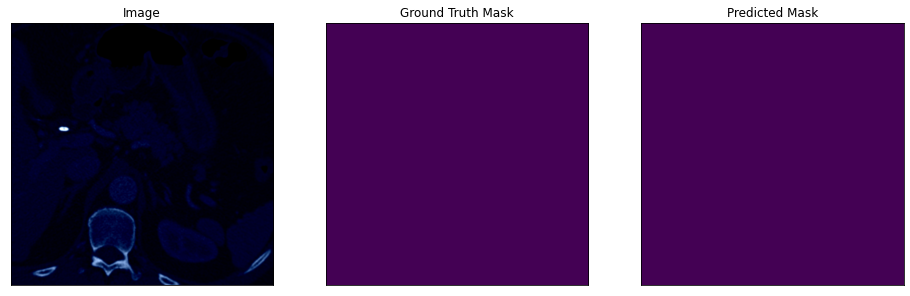

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


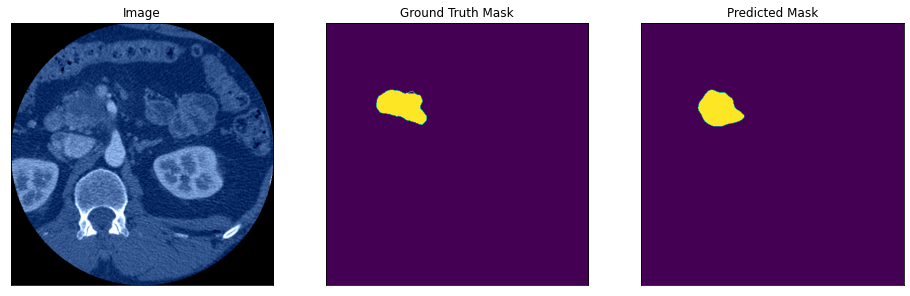

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


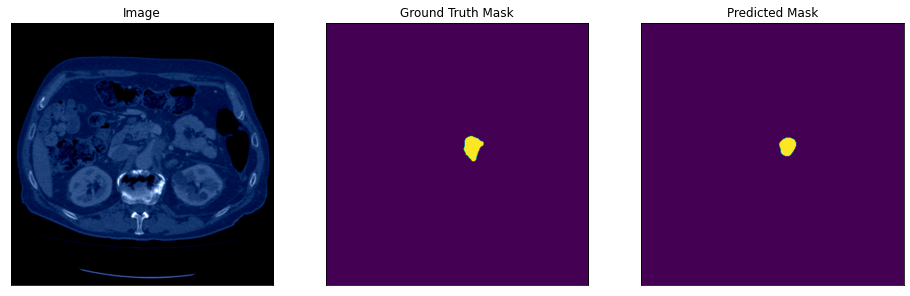

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


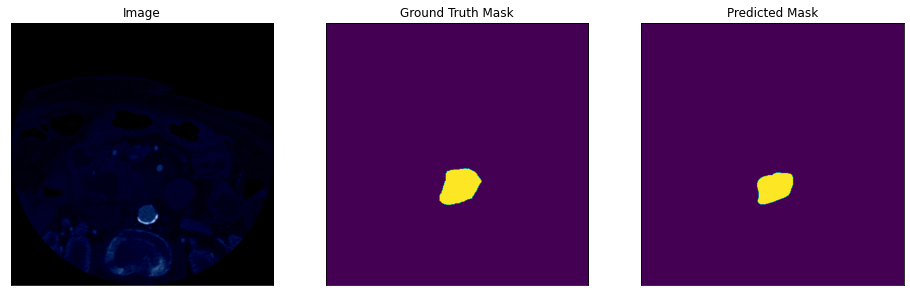

In [33]:
for i in range(5):
    n = np.random.choice(len(valid_dataset))
    
    image_vis = valid_dataset[n][0] #.astype('uint8')
    image, gt_mask = valid_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = (pr_mask.squeeze().detach().cpu().numpy().round())
    cls = 0
    visualize(
        image=image_vis.permute(1, 2, 0), 
        ground_truth_mask=gt_mask[CLASSES.index(CLASSES[cls])], 
        predicted_mask=pr_mask[CLASSES.index(CLASSES[cls])],
    )

In [ ]:
submission = open("solution.csv", "w")

for t in tqdm(test_loader, total=len(test_loader)):
    image, image_path = t
    image = image.to(DEVICE)
    image_path = image_path[0]
    pr_mask = best_model(image)
    for cls_ind, cls in enumerate(CLASSES):
        polygons = Mask(pr_mask.squeeze().detach().cpu().numpy().round()[cls_ind]).polygons()
        if polygons.segmentation != []:
            reg_exp = re.search('test\/(.*)\/Set_(.*)\/Slice_(.*)_CT_Image.png', image_path)
            patient_num    = reg_exp.group(1)
            slice_num      = reg_exp.group(3)
            polygon_points = ','.join(list(map(str, polygons.segmentation[0])))
            
            submission.write(
                patient_num + ',' + \
                slice_num + ',' + \
                cls + ',' + \
                polygon_points + '\n'
            )
    
submission.close()